Make J-plot from SOHO/LASCO C2 images to track the speed of a solar feature

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import UnivariateSpline
import astropy.io.fits as fits
import astropy.units as u
# from astropy import constants as const
from astropy.coordinates import SkyCoord
import sunpy.map
from PIL import Image
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch
from scipy import stats
import sunpy.sun.constants as const

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'
savedir = '/home/mnedal/repos/dias_work'

In [2]:
detector = 'C2'
os.makedirs(f'{savedir}/jplots/lasco_{detector}/bezier', exist_ok=True)

In [3]:
def split_datetime(start=None, end=None):
    START_DATE, START_TIME = start.split('T')
    END_DATE, END_TIME = end.split('T')

    START_YEAR, START_MONTH, START_DAY = START_DATE.split('-')
    END_YEAR, END_MONTH, END_DAY = END_DATE.split('-')

    START_HOUR, START_MINUTE, START_SECOND = START_TIME.split(':')
    END_HOUR, END_MINUTE, END_SECOND = END_TIME.split(':')

    datetime_dict = {
        'start_year': START_YEAR,
        'start_month': START_MONTH,
        'start_day': START_DAY,
        'start_hour': START_HOUR,
        'start_minute': START_MINUTE,
        'start_second': START_SECOND,
        
        'end_year': END_YEAR,
        'end_month': END_MONTH,
        'end_day': END_DAY,
        'end_hour': END_HOUR,
        'end_minute': END_MINUTE,
        'end_second': END_SECOND
    }
    return datetime_dict




def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec
    
    # Define the center point of the line (e.g., the center of the Sun)
    center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_obj.coordinate_frame)
    
    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point   = SkyCoord(center.Tx + line_length * np.cos(angle_rad), 
                           center.Ty + line_length * np.sin(angle_rad),
                           frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line



def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]



def remove_redundant_maps(maps):
    """
    Remove redundant SunPy maps, keeping only one map per unique timestamp.

    Parameters:
    maps (list): List of SunPy Map objects. Each map is expected to have a 'date-obs' 
                 key in its metadata that provides the observation timestamp.

    Returns:
    list: A list of unique SunPy Map objects, one per unique timestamp.
    
    Example:
    >>> unique_maps = remove_redundant_maps(list_of_sunpy_maps)
    """
    unique_maps = {}
    for m in maps:
        timestamp = m.latex_name
        if timestamp not in unique_maps:
            unique_maps[timestamp] = m
    return list(unique_maps.values())



def apply_runratio(maps):
    """
    Apply running-ratio image technique on EUV images.
    See: https://iopscience.iop.org/article/10.1088/0004-637X/750/2/134/pdf
        Inputs: list of EUV sunpy maps.
        Output: sequence of run-ratio sunpy maps.
    """
    runratio = [m / prev_m.quantity for m, prev_m in zip(maps[1:], maps[:-1])]
    m_seq_runratio = sunpy.map.Map(runratio, sequence=True)
    
    for m in m_seq_runratio:
        m.data[np.isnan(m.data)] = 1
        m.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=2)
        m.plot_settings['cmap'] = 'Greys_r'
    
    return m_seq_runratio



def enhance_contrast(image, vmin, vmax):
    """
    Enhance contrast by clipping and normalization.
    """
    image_clipped = np.clip(image, vmin, vmax)
    image_normalized = (image_clipped - vmin) / (vmax - vmin)
    return image_normalized



def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
    """
    Calculate vmin and vmax based on the 1st and 99th percentiles.
    """
    vmin = np.percentile(image, lower_percentile)
    vmax = np.percentile(image, upper_percentile)
    return vmin, vmax



def round_obstime(time=None):
    """
    Round the observation time to put it in the image title.
    Input : str, time (HH:MM:SS.sss)
    Output: str, datetime (YYYY-mm-DD HH:MM:SS)
    """
    from datetime import datetime, timedelta

    original_time_str = time

    # Convert the original time string to a datetime object
    original_time = datetime.strptime(original_time_str, '%H:%M:%S.%f')

    # Round the time to the nearest second
    rounded_time = original_time + timedelta(seconds=round(original_time.microsecond / 1e6))

    # Format the rounded time as 'HH:MM:SS'
    rounded_time_str = rounded_time.strftime('%H:%M:%S')
    
    return rounded_time_str



def load_lasco(start=None, end=None, detector='C2'):
    """
    Load SOHO/LASCO C2 or C3 images as sunpy maps.
    """
    dt_dict = split_datetime(start=start, end=end)
    data = sorted(glob.glob(f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['start_year']}{dt_dict['start_month']}{dt_dict['start_day']}*.jp2"))
    
    start_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['start_month']}{dt_dict['start_day']}T{dt_dict['start_hour']}{dt_dict['start_minute']}.jp2"
    end_file_to_find = f"{data_dir}/LASCO_{detector}/LASCO_{detector}_{dt_dict['end_year']}{dt_dict['end_month']}{dt_dict['end_day']}T{dt_dict['end_hour']}{dt_dict['end_minute']}.jp2"
    
    idx1 = data.index(start_file_to_find)
    idx2 = data.index(end_file_to_find)
    chosen_files = data[idx1:idx2]
    
    map_objects = []
    for i, file in enumerate(chosen_files):
        m = sunpy.map.Map(file)
        m.meta['bunit'] = 'ct' # a workaround for C2 jp2 images
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=250)
        map_objects.append(m)
        print(f'LASCO {detector} image {i} is done')
    return map_objects



def draw_bezier(x1=0, y1=0, x2=0, y2=0, control=[0,0]):
    """
    Draw a Bezier curve using the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1]).
    """
    A = np.array([x2, y2])
    B = np.array(control)
    C = np.array([x1, y1])

    A = A.reshape(2,1)
    B = B.reshape(2,1)
    C = C.reshape(2,1)
    
    t = np.arange(0, 1, 0.2).reshape(1,-1)
    
    # length = len(df.index)
    # t = np.linspace(0, 1, length).reshape(1,-1)
    # t = np.arange(0, length, 1).reshape(1,-1)
    
    P0 = A * t + (1 - t) * B
    P1 = B * t + (1 - t) * C
    Pfinal = P0 * t + (1 - t) * P1

    return Pfinal


def extract_bezier_values(array, x1, y1, x2, y2, control):
    """
    Extract the values of a Bezier curve at the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1])
    """
    Pfinal = draw_bezier(x1, y1, x2, y2, control)
    x_coords = np.round(Pfinal[0, :]).astype(int)
    y_coords = np.round(Pfinal[1, :]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords



# def extract_bezier_values(array, x1, y1, x2, y2, control):
#     """
#     Extract the values of a Bezier curve at the given control points.
#     The curve will be drawn from the point (x1, y1) to the point
#     (x2, y2) using the control points (control[0], control[1])
#     """
#     Pfinal = draw_bezier(x1, y1, x2, y2, control)
#     x_coords = Pfinal[0, :]  # Keep as floating-point
#     y_coords = Pfinal[1, :]  # Keep as floating-point

#     # Clip the coordinates to stay within array bounds
#     x_coords_int = np.clip(np.round(x_coords).astype(int), 0, array.shape[1] - 1)
#     y_coords_int = np.clip(np.round(y_coords).astype(int), 0, array.shape[0] - 1)

#     # Extract values along the Bézier curve
#     bezier_values = array[y_coords_int, x_coords_int]
    
#     return bezier_values, x_coords, y_coords



def generate_number_list(center, offset, count):
    """
    Generate a list of numbers around a given center number.

    Parameters:
    center (int or float): The central number of the list.
    offset (int or float): The increment by which numbers are spaced from the center.
    count (int): The number of numbers to include on each side of the center number.

    Returns:
    list: A list of numbers around the given center.

    Example usage:
        center_number = 0
        offset_value = 2
        count_around = 3
        number_list = generate_number_list(center_number, offset_value, count_around)
        print(number_list)
        [-6, -4, -2, 0, 2, 4, 6]
    """
    return [center + offset * i for i in range(-count, count + 1)]



def compute_standard_error(values_list):
    values_array = np.array(values_list)
    mean_values = np.mean(values_array, axis=0)
    standard_error = np.std(values_array, axis=0, ddof=1) / np.sqrt(values_array.shape[0])
    return mean_values, standard_error

In [4]:
lasco_c2_map_objects = load_lasco(start='2024-05-14T17:30:00', end='2024-05-14T20:00:00', detector='C2')

LASCO C2 image 0 is done
LASCO C2 image 1 is done
LASCO C2 image 2 is done
LASCO C2 image 3 is done
LASCO C2 image 4 is done
LASCO C2 image 5 is done
LASCO C2 image 6 is done
LASCO C2 image 7 is done
LASCO C2 image 8 is done
LASCO C2 image 9 is done
LASCO C2 image 10 is done
LASCO C2 image 11 is done
LASCO C2 image 12 is done
LASCO C2 image 13 is done
LASCO C2 image 14 is done
LASCO C2 image 15 is done
LASCO C2 image 16 is done
LASCO C2 image 17 is done
LASCO C2 image 18 is done
LASCO C2 image 19 is done
LASCO C2 image 20 is done
LASCO C2 image 21 is done
LASCO C2 image 22 is done
LASCO C2 image 23 is done
LASCO C2 image 24 is done
LASCO C2 image 25 is done
LASCO C2 image 26 is done
LASCO C2 image 27 is done
LASCO C2 image 28 is done
LASCO C2 image 29 is done
LASCO C2 image 30 is done
LASCO C2 image 31 is done
LASCO C2 image 32 is done
LASCO C2 image 33 is done
LASCO C2 image 34 is done
LASCO C2 image 35 is done
LASCO C2 image 36 is done
LASCO C2 image 37 is done
LASCO C2 image 38 is d

In [5]:
# remove redundant images
clean_maps_c2 = remove_redundant_maps(lasco_c2_map_objects)

print(f'Before:\nLASCO C2: {len(lasco_c2_map_objects)} images\n')
print(f'After:\nLASCO C2: {len(clean_maps_c2)} images')

Before:
LASCO C2: 150 images

After:
LASCO C2: 13 images


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


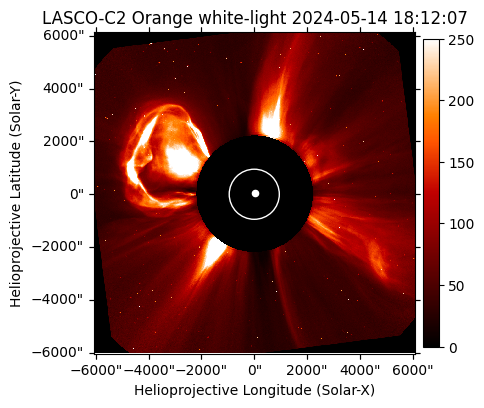

In [6]:
# Test plot ...
fig = plt.figure(figsize=[5,5])

m = clean_maps_c2[4]
ax = fig.add_subplot(111, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
pixel_coords = m.wcs.world_to_pixel(m.center)
x_pixel, y_pixel = pixel_coords
ax.scatter(x_pixel, y_pixel, c='w', s=20)
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.8)
plt.show()

In [7]:
# make run-diff maps
m_seq_runratio_c2 = apply_runratio(clean_maps_c2)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


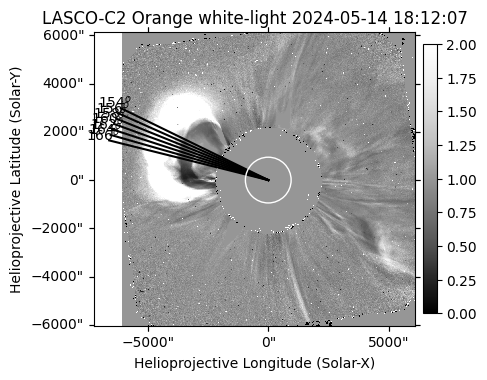

In [8]:
slits = True
centered_list = generate_centered_list(160, 2, 3)

fig = plt.figure(figsize=[5,5])

m = m_seq_runratio_c2[3]
ax = fig.add_subplot(111, projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
plt.colorbar(img, pad=0.02, shrink=0.7)

if slits:
    for value in centered_list:
        line = plot_line(angle_deg=value, length=6800, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')
plt.show()

## J-Maps for LASCO C2

Working on map 0 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


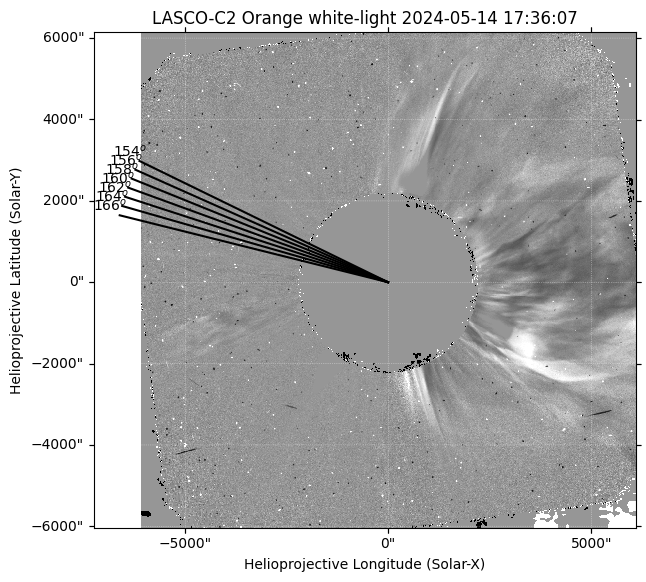

Working on map 1 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


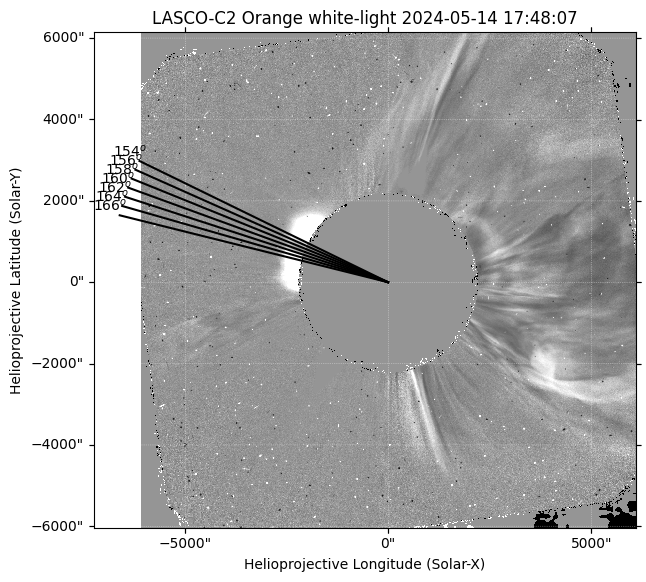

Working on map 2 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


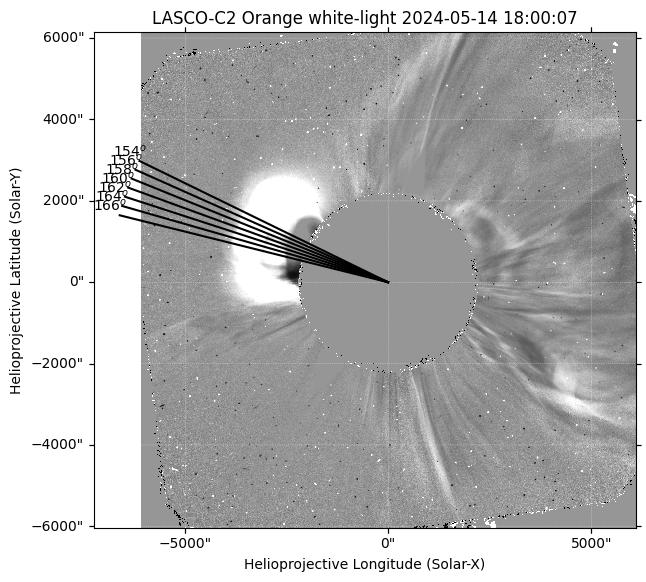

Working on map 3 ..


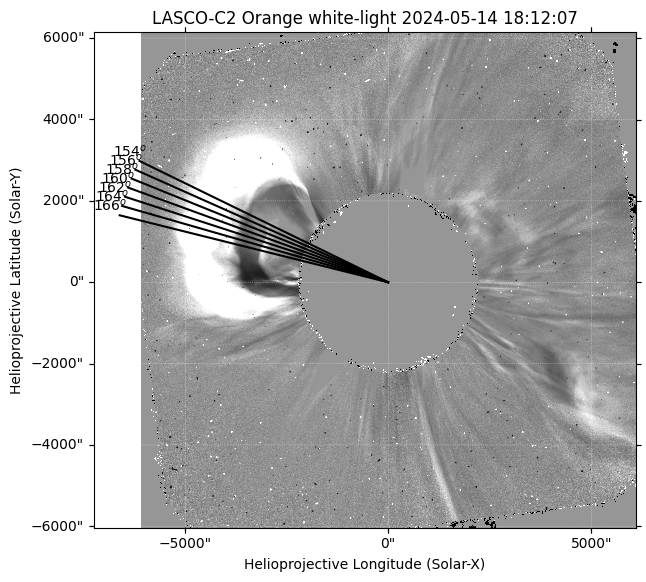

Working on map 4 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


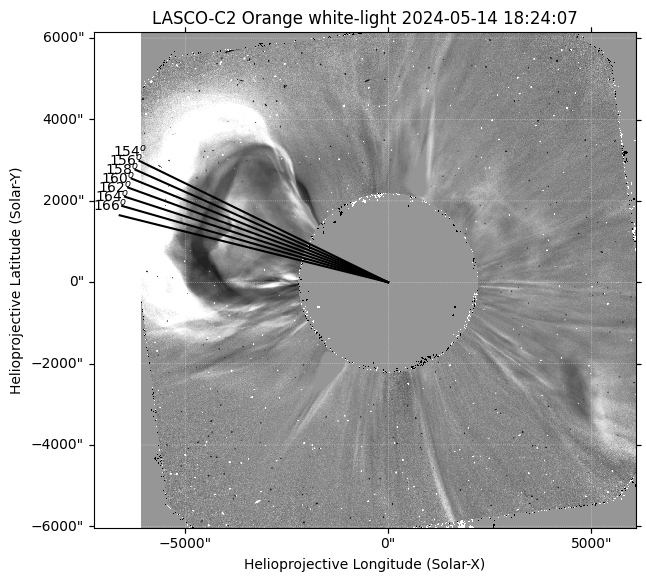

Working on map 5 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


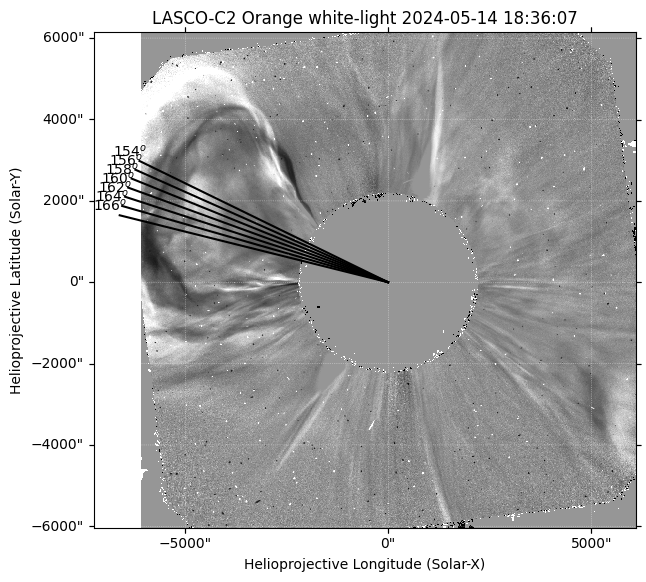

Working on map 6 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


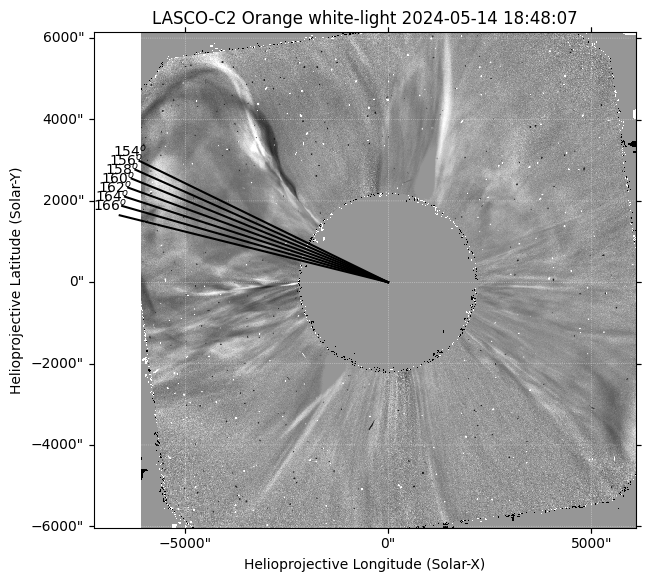

Working on map 7 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


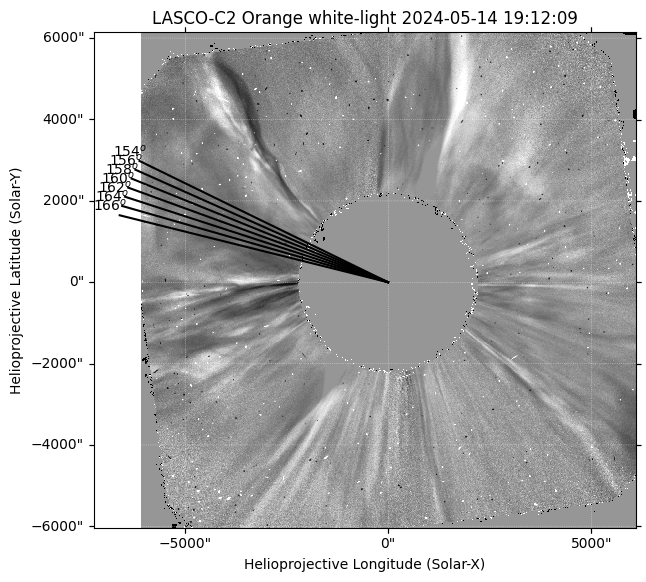

Working on map 8 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


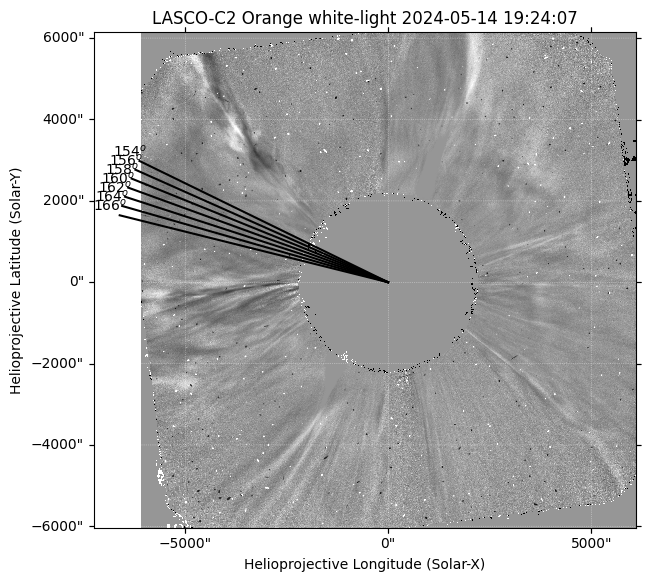

Working on map 9 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


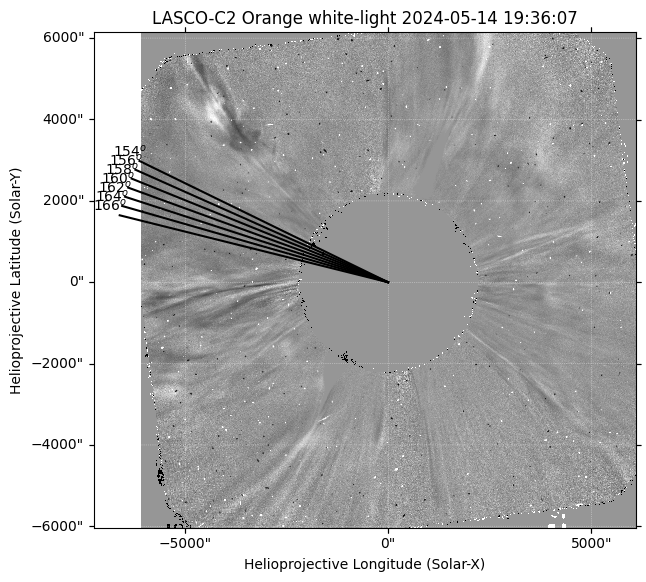

Working on map 10 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


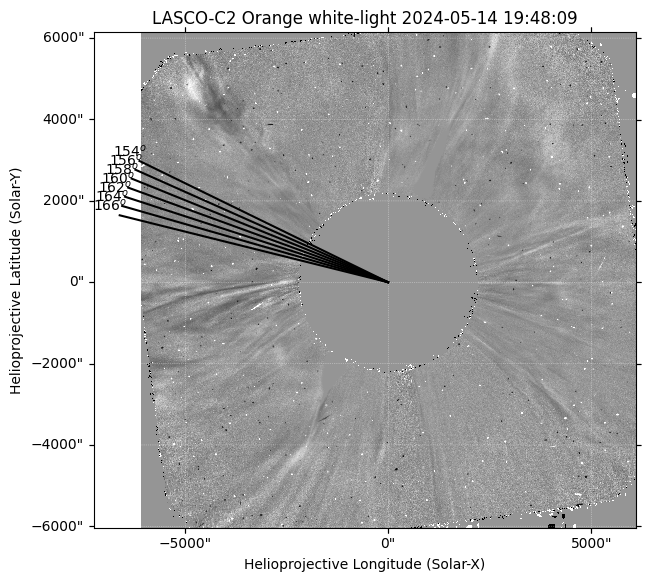

Working on map 11 ..
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


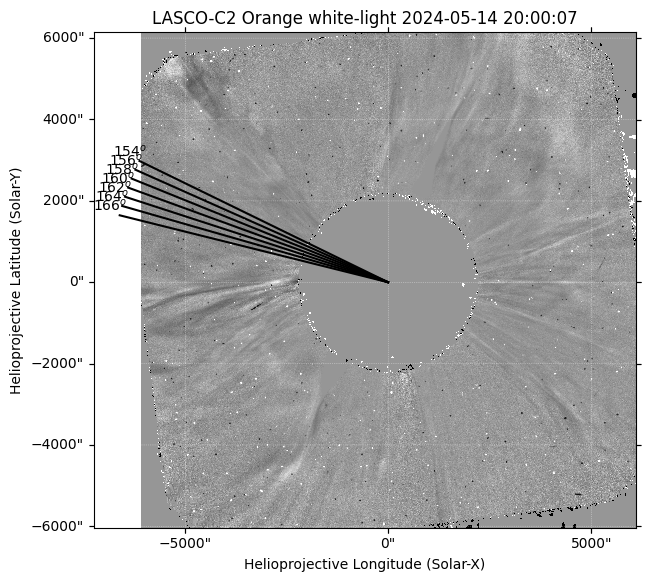

In [9]:
# Make a dictionary to hold the lists of lists
intensity_dict = {}
distances_dict = {}
output_obj = {}
jmaps_coords_list = {}

# Initialize each key with an empty list
for value in centered_list:
    intensity_dict[f'intensity_{value}deg'] = []
    distances_dict[f'distances_{value}deg'] = []
    output_obj[f'intensity_{value}deg'] = []
    output_obj[f'distances_{value}deg'] = []
    jmaps_coords_list[f'{value}'] = []

output_obj['time'] = []
output_obj['map_obj'] = []
output_obj['instrument'] = []

for i, m in enumerate(m_seq_runratio_c2):
    print(f'Working on map {i} ..')
    
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=m)
    m.plot(axes=ax)
    
    for value in centered_list:
        line = plot_line(angle_deg=value, length=6800, map_obj=m)
        ax.plot_coord(line, color='black')
        
        # Plot the number at the end of the line
        # Convert SkyCoord to pixel coordinates for plotting text
        line_lon, line_lat = line.Tx, line.Ty
        end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
        
        # Display the number at the end point
        ax.text(end_point_pixel.x.value - 20, end_point_pixel.y.value + 20, f'{value}$^o$',
                color='black', fontsize=10, ha='center', va='center')
        
        # obtain the coordinates of the map pixels that intersect that path
        intensity_coords_slit = sunpy.map.pixelate_coord_path(m, line)
        
        # Create mask to identify valid coordinates
        valid_mask = sunpy.map.contains_coordinate(m, intensity_coords_slit)
        
        # Apply the mask to filter valid coordinates
        valid_coords = intensity_coords_slit[valid_mask]
        
        # Pass those coordinates to extract the values for those map pixels
        intensity_slit = sunpy.map.sample_at_coords(m, valid_coords)
        
        # Calculate the angular separation between the first point and every other coordinate we extracted
        angular_separation_slit = valid_coords.separation(valid_coords[0]).to(u.arcsec)
        
        # Append the values to the lists
        intensity_dict[f'intensity_{value}deg'].append(list(intensity_slit.value))
        distances_dict[f'distances_{value}deg'].append(list(angular_separation_slit.value))
    
    output_obj['time'].append(m.date.iso)
    output_obj['map_obj'].append(m)
    output_obj['instrument'].append(f"{m.meta['instrume']}_{m.meta['detector']}")
    
    plt.show()

In [10]:
list(output_obj.keys())

['intensity_154deg',
 'distances_154deg',
 'intensity_156deg',
 'distances_156deg',
 'intensity_158deg',
 'distances_158deg',
 'intensity_160deg',
 'distances_160deg',
 'intensity_162deg',
 'distances_162deg',
 'intensity_164deg',
 'distances_164deg',
 'intensity_166deg',
 'distances_166deg',
 'time',
 'map_obj',
 'instrument']

In [11]:
datenum_arr = [mdates.date2num(pd.Timestamp(str(t))) for t in output_obj['time']]

for value in centered_list:
    intens = np.array(intensity_dict[f'intensity_{value}deg']).T
    height = np.array(distances_dict[f'distances_{value}deg'][0])
    output_obj[f'intensity_{value}deg'].append(intens)
    output_obj[f'distances_{value}deg'].append(height)

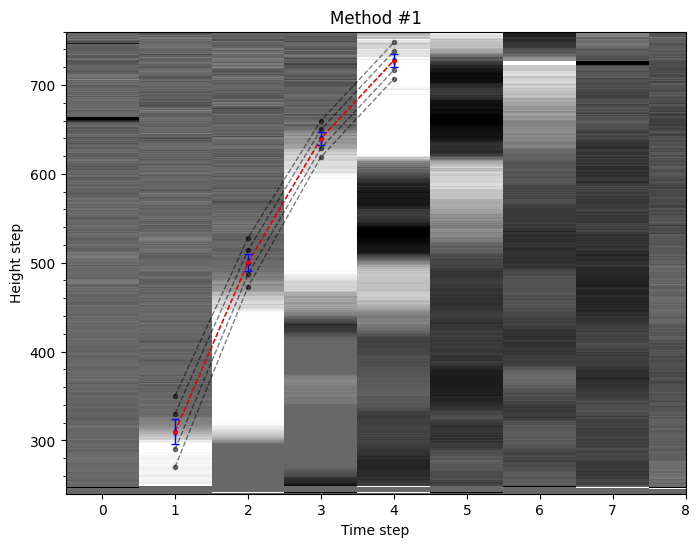

In [12]:
angle = 154

height = output_obj[f'distances_{angle}deg'][0].copy()
intens = output_obj[f'intensity_{angle}deg'][0].copy()
lasco_map = output_obj['map_obj'][0]

psudo_time = np.arange(len(datenum_arr))
psudo_dist = np.arange(len(height))

# # Define start and end points and control point for the Bézier curve
# x1, y1 = 1, 310
# x2, y2 = 5, 740
# control = [4, 850]

# Define start and end points and control point for the Bézier curve
X_start = generate_number_list(1, 0.2, 2)
X_end   = generate_number_list(5, 0.2, 2)
Y_start = generate_number_list(310, 20, 2)
Y_end   = generate_number_list(750, 20, 2)
control = [4, 850]

x_coords_list = []
y_coords_list = []

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(psudo_time, psudo_dist, intens, vmin=0.5, vmax=2, cmap='Greys_r')

# Extract values along the Bézier curve
for (x1, y1, x2, y2) in zip(X_start, Y_start, X_end, Y_end):
    _, x_coords, y_coords = extract_bezier_values(intens, x1, y1, x2, y2, control)
    x_coords_list.append(x_coords[:-1])
    y_coords_list.append(y_coords[:-1])
    ax.plot(x_coords[:-1], y_coords[:-1], 'ko--', linewidth=1, markersize=3, alpha=0.5)

# Compute mean and standard error for x and y coordinates
mean_x_coords, standard_error_x = compute_standard_error(x_coords_list)
mean_y_coords, standard_error_y = compute_standard_error(y_coords_list)

# Plot the mean Bezier curve with error bars
ax.plot(mean_x_coords, mean_y_coords, 'ro--', linewidth=1, markersize=2)
ax.errorbar(mean_x_coords, mean_y_coords,
            xerr=standard_error_x, yerr=standard_error_y,
            fmt='ro', ecolor='blue', barsabove=False, markersize=2, elinewidth=1, capsize=3)

ax.set_xlabel('Time step')
ax.set_ylabel('Height step')
ax.set_title('Method #1')
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_ylim(bottom=240, top=psudo_dist[-1])
ax.set_xlim(right=8)
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


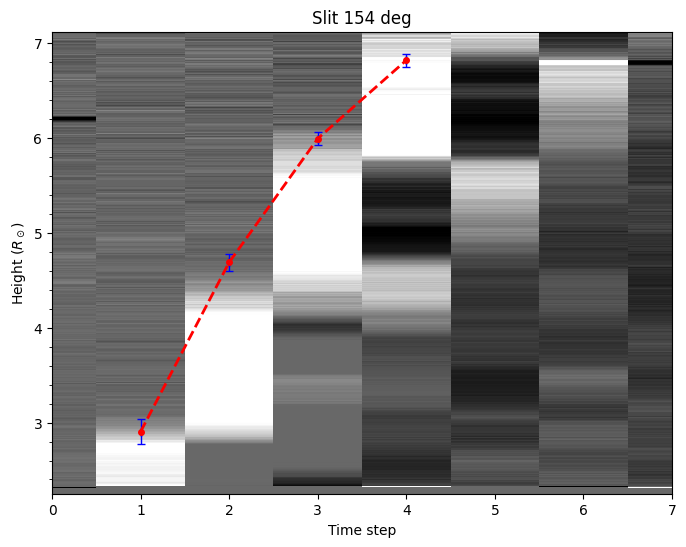

In [13]:
# conversion from arcsec to solar radius
dist_rsun = height/lasco_map.rsun_obs.value

fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(psudo_time, dist_rsun, intens, vmin=0.5, vmax=2, cmap='Greys_r')

mean_y_coords, standard_error_y = compute_standard_error(dist_rsun[y_coords_list])

ax.errorbar(mean_x_coords, mean_y_coords,
            xerr=standard_error_x, yerr=standard_error_y,
            fmt='ro--', ecolor='blue', barsabove=False, linewidth=2,
            markersize=4, elinewidth=1, capsize=3)

ax.set_xlabel('Time step')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(f'Slit {angle} deg')
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_ylim(bottom=2.25, top=dist_rsun[-1])
ax.set_xlim(left=0, right=7)
plt.show()

In [14]:
jmaps_coords_list

{'154': [], '156': [], '158': [], '160': [], '162': [], '164': [], '166': []}

In [15]:
# # Export the list as a pickle file
# import pickle

# with open('./jmap_extracted_values_LASCO_C2.pkl', 'wb') as f:
#     pickle.dump(extracted_values, f)

## Looping over all slits doesn't give a good result since every slit has a bit different variation of the feature. So I have to tweak the curve parameters one by one

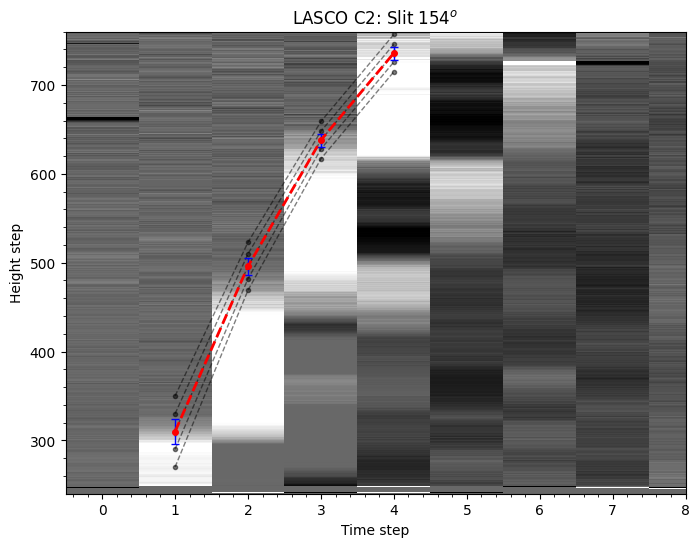

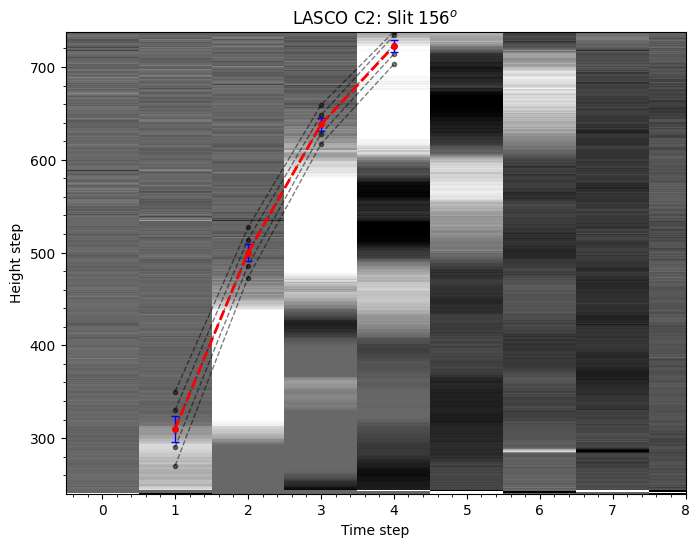

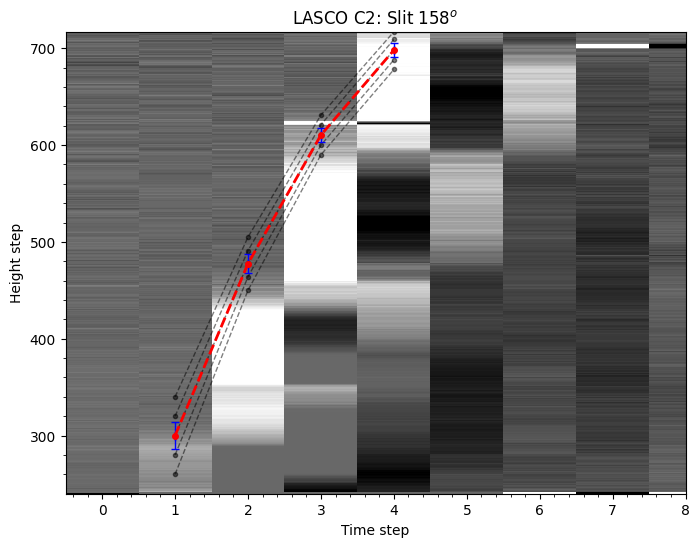

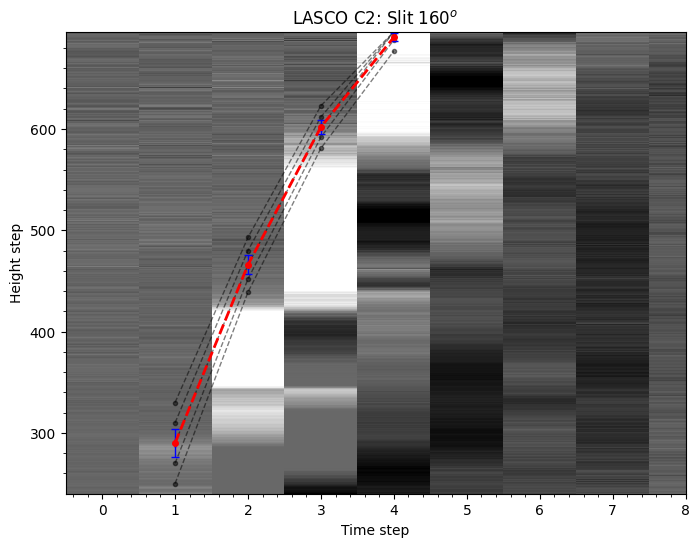

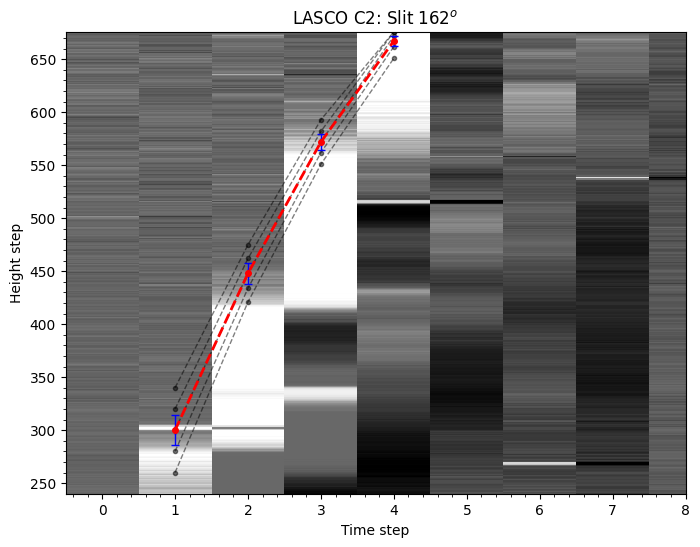

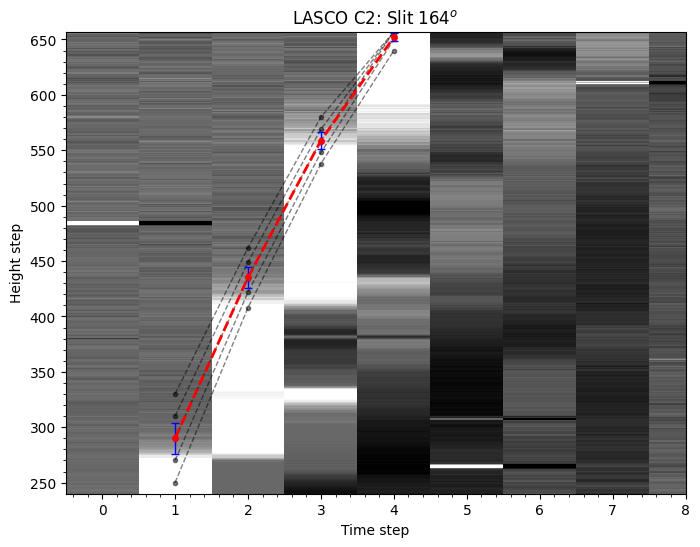

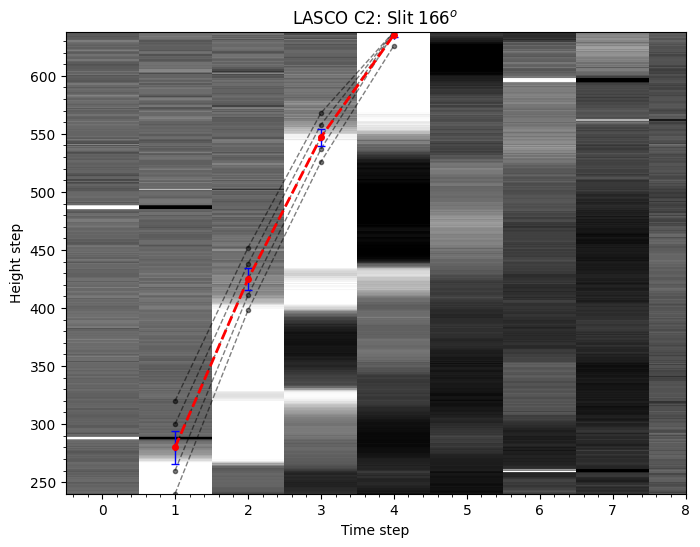

In [16]:
# Define start and end points and control point for the Bézier curve
xx_start = 1
xx_end   = 5

yy_start = [310, 310, 300, 290, 300, 290, 280]
yy_end   = [800, 740, 740, 770, 800, 800, 780]
controls = [ [4,830], [4,850], [4,800], [4,780], [4,700], [4,680], [4,670] ]

for i, angle in enumerate(centered_list):
    
    X_start = generate_number_list(1, 0.2, 2)
    X_end   = generate_number_list(5, 0.2, 2)
    Y_start = generate_number_list(yy_start[i], 20, 2)
    Y_end   = generate_number_list(yy_end[i], 20, 2)
    control = controls[i]

    height = output_obj[f'distances_{angle}deg'][0].copy()
    intens = output_obj[f'intensity_{angle}deg'][0].copy()
    
    # Define a psudo time and distance axes for the Bezier curve method to work
    psudo_time = np.arange(len(datenum_arr))
    psudo_dist = np.arange(len(height))
    
    x_coords_list = []
    y_coords_list = []
    
    fig = plt.figure(figsize=[8,6])
    ax = fig.add_subplot(111)
    ax.pcolormesh(psudo_time, psudo_dist, intens, vmin=0.5, vmax=2, cmap='Greys_r')
    
    # Extract values along the Bézier curves
    for (x1, y1, x2, y2) in zip(X_start, Y_start, X_end, Y_end):
        _, x_coords, y_coords = extract_bezier_values(intens, x1, y1, x2, y2, control)
        x_coords_list.append(x_coords[:-1])
        y_coords_list.append(y_coords[:-1])
        ax.plot(x_coords[:-1], y_coords[:-1], 'ko--', linewidth=1, markersize=3, alpha=0.5)
    
    # Compute mean and standard error for x and y coordinates
    mean_x_coords, standard_error_x = compute_standard_error(x_coords_list)
    mean_y_coords, standard_error_y = compute_standard_error(y_coords_list)
    
    # Store the final curves values
    df = pd.DataFrame({
        'x_coords': mean_x_coords,
        'y_coords': mean_y_coords,
        'x_err': standard_error_x,
        'y_err': standard_error_y,
        'x1': xx_start,
        'x2': xx_end,
        'y1': yy_start[i],
        'y2': yy_end[i],
        'control_point_x': control[0],
        'control_point_y': control[1]
    })
    jmaps_coords_list[f'{angle}'].append(df)
    
    # Plot the mean Bezier curve with error bars
    ax.errorbar(mean_x_coords, mean_y_coords,
                xerr=standard_error_x, yerr=standard_error_y,
                fmt='ro--', ecolor='blue', barsabove=False, linewidth=2,
                markersize=4, elinewidth=1, capsize=3)
    
    ax.set_xlabel('Time step')
    ax.set_ylabel('Height step')
    ax.set_title(f'LASCO C2: Slit {angle}$^o$')
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
    ax.set_ylim(bottom=240, top=psudo_dist[-1])
    ax.set_xlim(right=8)
    plt.show()

In [17]:
# print(f'Number of slits: {len(jmaps_coords_list)}')
# print(f'Their data:\n{jmaps_coords_list}')

## Fitting the points

### Start with one angle as an example

In [18]:
centered_list

[154, 156, 158, 160, 162, 164, 166]

In [19]:
angle = 154
df = jmaps_coords_list[f'{angle}'][0].copy()
display(df)

x_coords  y_coords  x_err      y_err  x1  x2   y1   y2  control_point_x  \
0       1.0     310.0    0.0  14.142136   1   5  310  800                4   
1       2.0     496.0    0.0   9.617692   1   5  310  800                4   
2       3.0     638.0    0.0   7.355270   1   5  310  800                4   
3       4.0     736.0    0.0   7.355270   1   5  310  800                4   

   control_point_y  
0              830  
1              830  
2              830  
3              830

In [20]:
# Extract time and distance arrays from the selected coordinates
height    = output_obj[f'distances_{angle}deg'][0].copy()
intens    = output_obj[f'intensity_{angle}deg'][0].copy()
lasco_map = output_obj['map_obj'][0]

x_coords = df['x_coords'].astype('int')
times_num = np.array(datenum_arr)[x_coords]
df['time'] = times_num

y_coords = df['y_coords']
y_coords = round(y_coords).astype('int')
distances = height[y_coords] # in arcsec
df['distance'] = distances

# Perform linear regression to fit a line
slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/lasco_map.rsun_obs
print(conversion_factor)

695700.0 km
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
733.1010842980302 km / arcsec


In [21]:
# convert distance from arcsec to km
df['distance_km'] = df['distance'] * conversion_factor.value

# calculate the distance difference in km
df['distance_diff_km'] = df['distance_km'].diff()

# convert time to datetime format
df['datetime'] = [mdates.num2date(t) for t in df['time']]

# calculate the time difference in seconds
df['time_diff_s'] = df['datetime'].diff().dt.total_seconds()

# calculate the speed in km/s
df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']

# drop the first row which will have NaN values for the differences
df.dropna(inplace=True)

# Filter out rows where time_diff_s is 0 and speed_km_s is inf
df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]

In [22]:
display(df)

x_coords  y_coords  x_err     y_err  x1  x2   y1   y2  control_point_x  \
1       2.0     496.0    0.0  9.617692   1   5  310  800                4   
2       3.0     638.0    0.0  7.355270   1   5  310  800                4   
3       4.0     736.0    0.0  7.355270   1   5  310  800                4   

   control_point_y          time     distance   distance_km  distance_diff_km  \
1              830  19857.750086  4411.291660  3.233923e+06      1.213033e+06   
2              830  19857.758424  5671.813495  4.158013e+06      9.240899e+05   
3              830  19857.766756  6543.885814  4.797330e+06      6.393172e+05   

                          datetime  time_diff_s   speed_km_s  
1 2024-05-14 18:00:07.457000+00:00      719.891  1685.022669  
2 2024-05-14 18:12:07.848000+00:00      720.391  1282.761617  
3 2024-05-14 18:24:07.740000+00:00      719.892   888.073715

In [23]:
# Calculate spline fit
spline = UnivariateSpline(times_num, distances, k=1, s=None)  # s=0 for interpolation through all points

# Generate the spline line
spline_times = np.linspace(min(times_num), max(times_num), 1000)
spline_distances = spline(spline_times)

# Calculate the derivative of spline_distances with respect to spline_times
spline_velocity = spline.derivative()(spline_times)

# Convert velocity (in arcsec/day) to speed in km/s
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s

# Calculate the polynomial fit
polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
polyfit_line = np.polyval(polyfit_coeff, spline_times)

# Calculate the derivative of the polynomial fit (velocity)
polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s

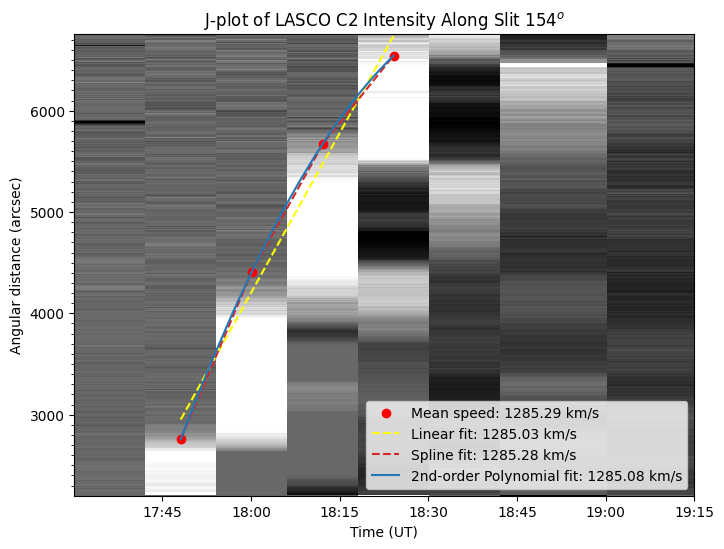

In [24]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ax.pcolormesh(datenum_arr, height, intens, vmin=0.5, vmax=2, cmap='Greys_r')

# Plot the fitted line
fit_line = slope*times_num + intercept

# Calculate the speed (slope in arcsec/day to speed in km/s)
# 1 arcsec ≈ 733 km on the Sun's surface
# 1 day = 86400 seconds
speed_fit = slope * conversion_factor.value/86400  # km/s
speed = df['speed_km_s'].mean()

# Plot the selected points
ax.plot(times_num, distances, 'ro', label=f'Mean speed: {speed:.2f} km/s')
ax.plot(times_num, fit_line, ls='--', color='yellow',
        label=f'Linear fit: {speed_fit:.2f} km/s')

# Plot the spline fit line
ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
        label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')

# Plot the polynomial fit line
ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
           label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Angular distance (arcsec)')
ax.set_title(f"J-plot of {output_obj['instrument'][0].replace('_',' ')} Intensity Along Slit {angle}$^o$")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.legend(loc='lower right')
ax.set_xlim(right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 19:15:00"))
ax.set_ylim(bottom=2200)
plt.show()

### Export the tables and J-Maps with fitting for all slits

[19857.74175424 19857.75008631 19857.75842417 19857.76675625]
[2756.63218665 4411.29165988 5671.8134949  6543.88581403]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


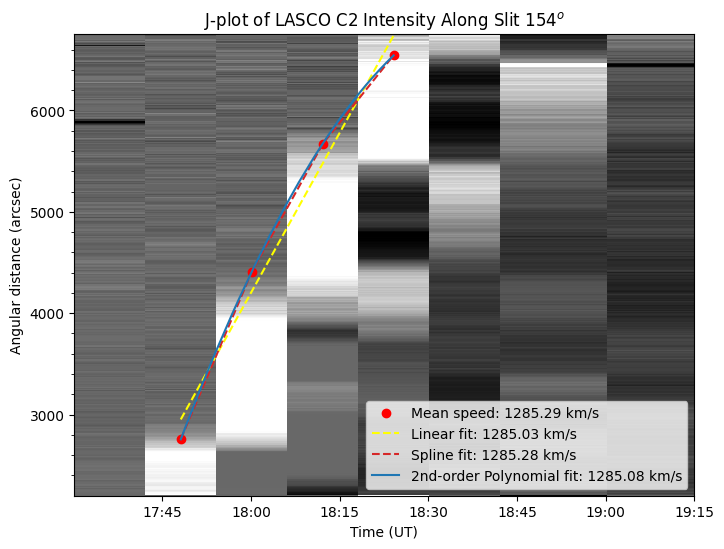

[19857.74175424 19857.75008631 19857.75842417 19857.76675625]
[2790.93152153 4506.10079421 5746.2255119  6512.78887457]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


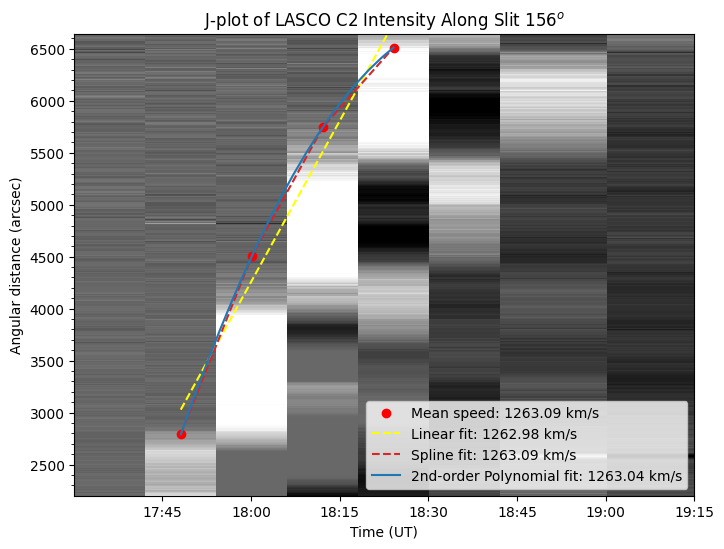

[19857.74175424 19857.75008631 19857.75842417 19857.76675625]
[2737.82207807 4365.91825904 5571.75885389 6377.63221308]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


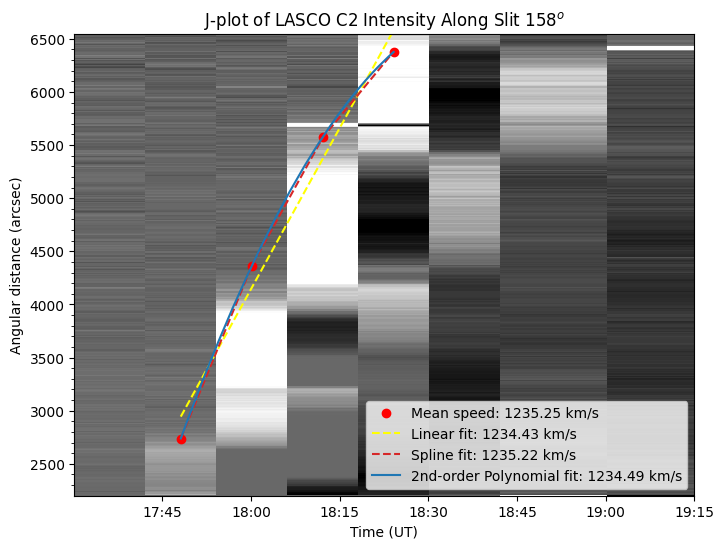

[19857.74175424 19857.75008631 19857.75842417 19857.76675625]
[2687.98378132 4321.31258318 5585.32629793 6409.16555683]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


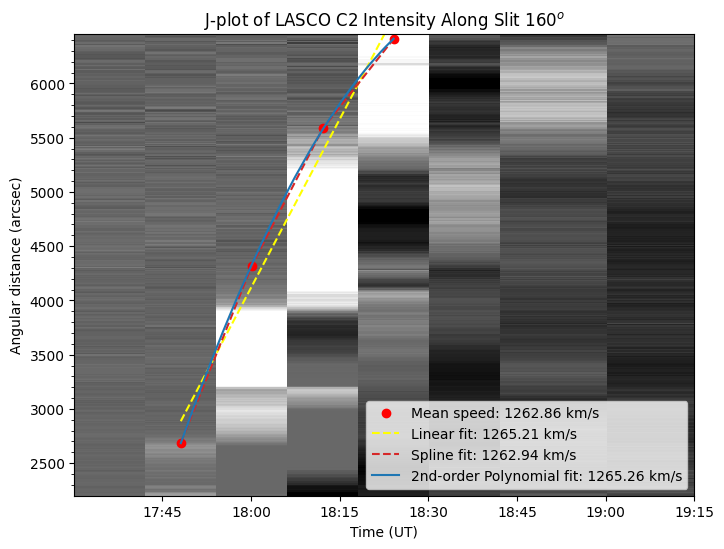

[19857.74175424 19857.75008631 19857.75842417 19857.76675625]
[2829.72144836 4229.25028369 5395.15330681 6293.86533366]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


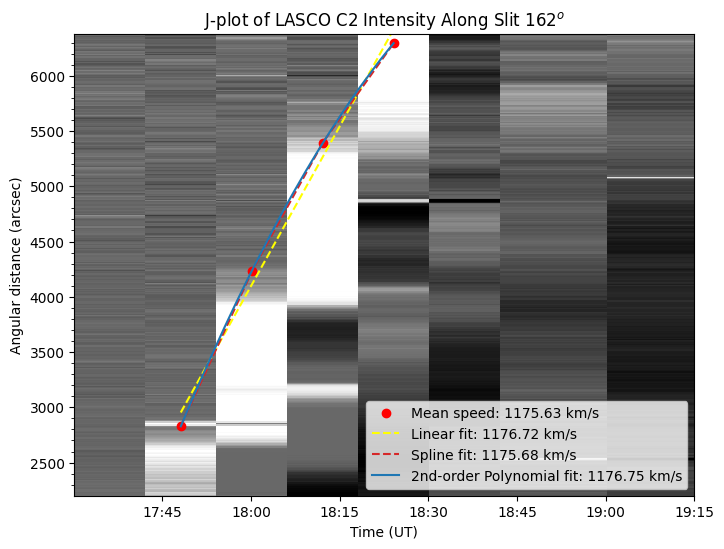

[19857.74175424 19857.75008631 19857.75842417 19857.76675625]
[2786.81944399 4183.98088201 5373.33015878 6265.11409443]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


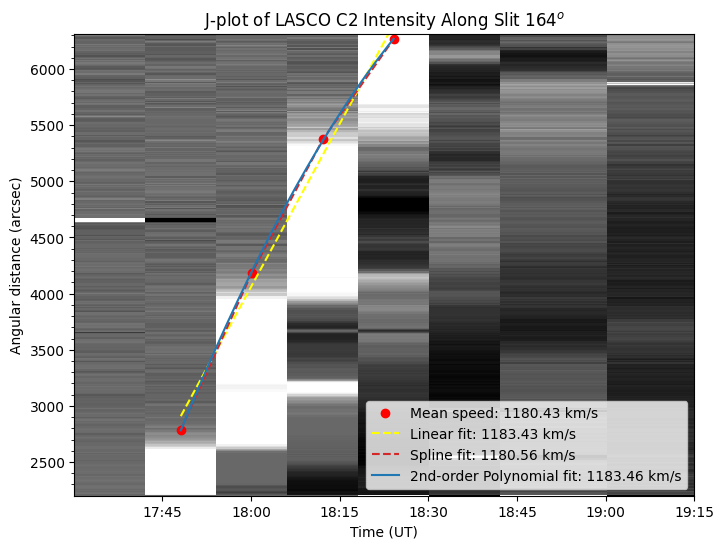

[19857.74175424 19857.75008631 19857.75842417 19857.76675625]
[2747.47493124 4169.95279518 5361.30988725 6229.35414533]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


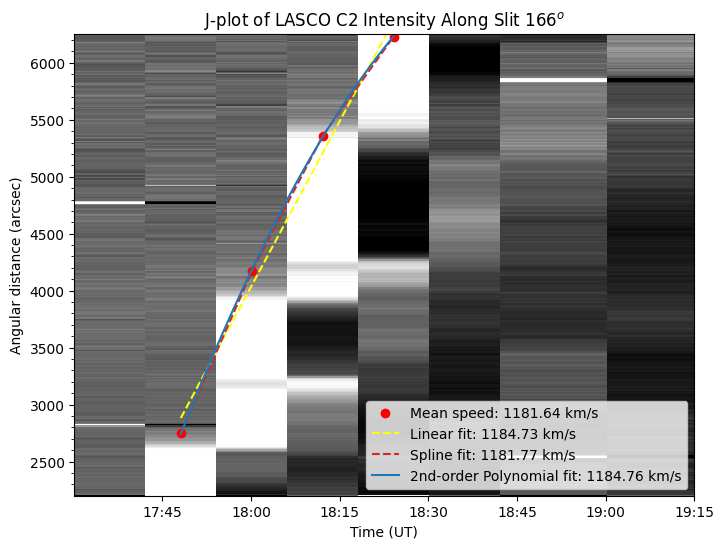

In [25]:
for angle in centered_list:
    
    df = jmaps_coords_list[f'{angle}'][0].copy()

    height = output_obj[f'distances_{angle}deg'][0].copy()
    intens = output_obj[f'intensity_{angle}deg'][0].copy()
    
    # Extract time and distance arrays from the selected coordinates
    x_coords = df['x_coords'].astype('int')
    times_num = np.array(datenum_arr)[x_coords]
    df['time'] = times_num
    
    y_coords = df['y_coords']
    y_coords = round(y_coords).astype('int')
    distances = height[y_coords] # in arcsec
    df['distance'] = distances

    print(f'{times_num}\n{distances}\n\n')
    
    # Perform linear regression to fit a line
    slope, intercept, r_value, p_value, std_err = stats.linregress(times_num, distances)
    
    # get the radius of the solar disk
    sol_rad = const.equatorial_radius.to(u.km)
    
    # conversion factor from arcsec to km
    conversion_factor = sol_rad/output_obj['map_obj'][0].rsun_obs
    
    # convert distance from arcsec to km
    df['distance_km'] = df['distance'] * conversion_factor.value
    
    # calculate the distance difference in km
    df['distance_diff_km'] = df['distance_km'].diff()
    
    # convert time to datetime format
    df['datetime'] = [mdates.num2date(t) for t in df['time']]
    
    # calculate the time difference in seconds
    df['time_diff_s'] = df['datetime'].diff().dt.total_seconds()
    
    # calculate the speed in km/s
    df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']

    # export data
    event_date = str(mdates.num2date(times_num[0]).date()).replace('-','')
    df.to_csv(f'{savedir}/jplots/lasco_{detector}/bezier/jmap_lasco_{detector}_{event_date}_slit_{angle}.csv')
    
    # # drop the first row which will have NaN values for the differences
    # df.dropna(inplace=True)
    
    # Calculate spline fit
    spline = UnivariateSpline(times_num, distances, k=1, s=None)  # s=0 for interpolation through all points
    
    # Generate the spline line
    spline_times = np.linspace(min(times_num), max(times_num), 1000)
    spline_distances = spline(spline_times)
    
    # Calculate the derivative of spline_distances with respect to spline_times
    spline_velocity = spline.derivative()(spline_times)
    
    # Convert velocity (in arcsec/day) to speed in km/s
    # 1 arcsec ≈ 733 km on the Sun's surface
    # 1 day = 86400 seconds
    speed_spline = spline_velocity * conversion_factor.value / 86400  # km/s
    
    # Calculate the polynomial fit
    polyfit_coeff = np.polyfit(times_num, distances, 2)  # Fit a 2nd order polynomial
    polyfit_line = np.polyval(polyfit_coeff, spline_times)
    
    # Calculate the derivative of the polynomial fit (velocity)
    polyfit_velocity = np.polyval(np.polyder(polyfit_coeff), spline_times)
    speed_polyfit = polyfit_velocity * conversion_factor.value / 86400  # km/s
    
    # plots the fitting lines
    fig = plt.figure(figsize=[8,6])
    ax = fig.add_subplot(111)
    ax.pcolormesh(datenum_arr, height, intens, vmin=0.5, vmax=2, cmap='Greys_r')
    
    # Plot the fitted line
    fit_line = slope*times_num + intercept
    
    # Calculate the speed (slope in arcsec/day to speed in km/s)
    # 1 arcsec ≈ 733 km on the Sun's surface
    # 1 day = 86400 seconds
    speed_fit = slope * conversion_factor.value/86400  # km/s
    speed = df['speed_km_s'].mean()
    
    # Plot the selected points
    ax.plot(times_num, distances, 'ro', label=f'Mean speed: {speed:.2f} km/s')
    ax.plot(times_num, fit_line, ls='--', color='yellow',
            label=f'Linear fit: {speed_fit:.2f} km/s')
    
    # Plot the spline fit line
    ax.plot(spline_times, spline_distances, ls='--', color='tab:red',
            label=f'Spline fit: {np.nanmean(speed_spline):.2f} km/s')
    
    # Plot the polynomial fit line
    ax.plot(spline_times, polyfit_line, ls='-', color='tab:blue',
               label=f'2nd-order Polynomial fit: {np.nanmean(speed_polyfit):.2f} km/s')
    
    ax.set_xlabel('Time (UT)')
    ax.set_ylabel('Angular distance (arcsec)')
    ax.set_title(f"J-plot of {output_obj['instrument'][0].replace('_',' ')} Intensity Along Slit {angle}$^o$")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
    ax.legend(loc='lower right')
    ax.set_xlim(right=pd.Timestamp(f"{output_obj['time'][0].split(' ')[0]} 19:15:00"))
    ax.set_ylim(bottom=2200, top=height[-1])
    fig.savefig(f'{savedir}/jplots/lasco_{detector}/bezier/jmap_lasco_{detector}_{event_date}_slit_{angle}.png', dpi=300, format='png', bbox_inches='tight')
    plt.show()